In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cbook
import polyscope as ps
from scipy.sparse import dok_matrix

In [2]:
# Just to avoid more typing than necessary
def imshow(input):
    plt.axis('off')
    plt.imshow(input)

## Image loading
 Run the cell below to load the **image** and image **normals**, and plot them side by side
 Note that our image values are RGB in the range $[0, 1)$
 We will convert this to HSV so that we can more easily adjust luminance (by modifying V)

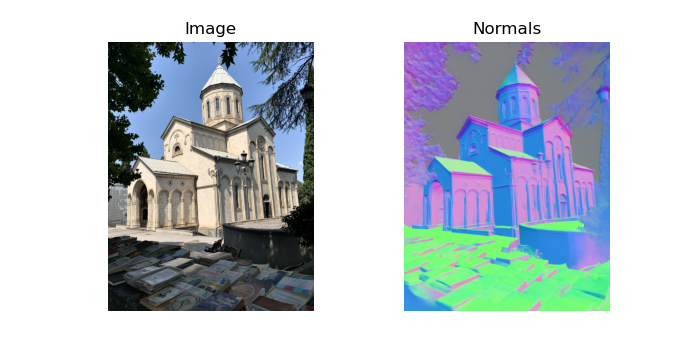

In [2]:
image = plt.imread('./data/mid_level_examples/church/input.png')
normals = plt.imread('./data/mid_level_examples/church/normals.png')

fig, ax = plt.subplot_mosaic([['image', 'normals']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

#light_source = [(16, 14)]
#x, y = zip(*light_source)
#ax['image'].plot(x, y, 'o')

plt.show()

Now we will implicitly define a radial light source

In [3]:
class LightSource:
    def __init__(self):
        self.origin = np.array([250, 250])
        self.radius = 250

    def _query(self, coordinate, alpha=0.005):
        euclidean_distance = npl.norm(self.origin - coordinate)
        # print(f"{euclidean_distance= }")
        return 1.0 / (1 + alpha * euclidean_distance)
        """if euclidean_distance > self.radius:
            return 0
        else:
            return 1.0 / (1 + alpha * euclidean_distance)"""

    def draw_image(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for i, _ in enumerate(image_hsv[0]):
            for j, _ in enumerate(image_hsv[1]):
                light_v = self._query(np.array([i, j]))
                image_hsv[i, j, 2] += light_v
        image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
        return image_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


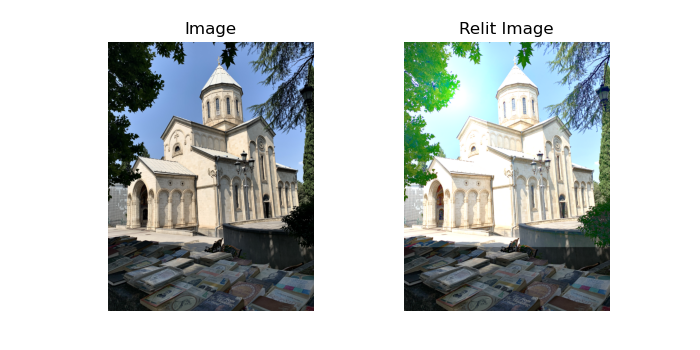

In [4]:
light = LightSource()

image_relit = light.draw_image(image)

fig, ax = plt.subplot_mosaic([['image', 'image_relit']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['image_relit'].imshow(image_relit)
ax['image_relit'].axis('off')
ax['image_relit'].set_title('Relit Image')

markers = [(250, 250)]
x, y = zip(*markers)
# ax['image_relit'].plot(x, y, 'o')

plt.show()

### Here we will create a 3D mesh grid using the depth image, and apply ray casting to simulate light in 3D space
The parameter *depth_resolution* determines the number of discrete points sampled in the z direction.
The parameter *light_origin* is used to set the point of the light within the scene


In [42]:
depth_resolution = 128
light_origin = np.array([600, 450, 0])


depth_map = cv2.imread('data/mid_level_examples/church/depth_bmd_ordinal.png', cv2.IMREAD_ANYDEPTH)
depth_map = np.array(depth_map / np.max(depth_map) * depth_resolution, dtype='uint8')
depth_map = depth_resolution - depth_map
imshow(depth_map)
print(f"{depth_map.shape= }")
print(f"{np.min(depth_map)= }, {np.max(depth_map)= }")

depth_map.shape= (1216, 928)
np.min(depth_map)= 0, np.max(depth_map)= 128


In [43]:
x = np.arange(0, depth_map.shape[1])
y = np.arange(0, depth_map.shape[0])
z = np.arange(0, depth_resolution)
print(f"{x.shape= }, {y.shape= }, {z.shape= }")

# Create sparse meshgrids for use in computing euclidean distance from the light source
xx, yy, zz = np.meshgrid(x, y, z, sparse=True)
print(f"{xx.shape= }, {yy.shape= }, {zz.shape= }")

x.shape= (928,), y.shape= (1216,), z.shape= (128,)
xx.shape= (1, 928, 1), yy.shape= (1216, 1, 1), zz.shape= (1, 1, 128)


In [44]:
def distance_3d(x_point, y_point, z_point, xx, yy, zz):
    point1 = np.array([x_point, y_point, z_point])
    point2 = np.array([xx, yy, zz])
    return np.linalg.norm(point2 - point1)

distances = distance_3d(light_origin[0], light_origin[1], light_origin[2], xx, yy, zz)
print(f"{distances.shape= }")
print(f"{light_origin= }")
print(f"{distances[250, 250, 8]= }, {distances[250, 255, 8]= }")

/tmp/ipykernel_9295/3278405629.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  point2 = np.array([xx, yy, zz])


distances.shape= (1216, 928, 128)
light_origin= array([600, 450,   0])
distances[250, 250, 8]= 403.1922618305069, distances[250, 255, 8]= 398.8596244294476


In [45]:
def unit_direction_3d(x_point, y_point, z_point, xx, yy, zz):
    point1 = np.array([x_point, y_point, z_point])
    point2 = np.array([xx, yy, zz])
    magnitude = np.linalg.norm(point2 - point1)
    directions_meshgrids = (point2 - point1)
    direction_x = np.ones_like(magnitude) * directions_meshgrids[0]
    direction_y = np.ones_like(magnitude) * directions_meshgrids[1]
    direction_z = np.ones_like(magnitude) * directions_meshgrids[2]
    direction_vectors = np.stack((direction_x, direction_y, direction_z), axis=-1)
    # print(f"{magnitude.shape= }")
    # print(f"{direction_vectors.shape= }")
    return direction_vectors / magnitude[..., np.newaxis]

direction_vector_field = unit_direction_3d(light_origin[0], light_origin[1], light_origin[2], xx, yy, zz)
print(f'{direction_vector_field.shape= }')
print(f"{light_origin= }")
print(f"Direction to the light origin: {direction_vector_field[250, 250, 8]= }, moving along x-axis: {direction_vector_field[255, 250, 8]= },"
      f" moving along y-axis {direction_vector_field[250, 255, 8]= }, moving along z-axis {direction_vector_field[250, 250, 10]= }, some random point {direction_vector_field[418, 620, 14]= }")
for i in range(10):
    print(f"{direction_vector_field[251+i, 251+i, 8]}")

/tmp/ipykernel_9295/3990377251.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  point2 = np.array([xx, yy, zz])


direction_vector_field.shape= (1216, 928, 128, 3)
light_origin= array([600, 450,   0])
Direction to the light origin: direction_vector_field[250, 250, 8]= array([-0.86807222, -0.49604127,  0.01984165]), moving along x-axis: direction_vector_field[255, 250, 8]= array([-0.87339389, -0.48660517,  0.01996329]), moving along y-axis direction_vector_field[250, 255, 8]= array([-0.86496597, -0.50142955,  0.02005718]), moving along z-axis direction_vector_field[250, 250, 10]= array([-0.86797611, -0.49598635,  0.02479932]), some random point direction_vector_field[418, 620, 14]= array([ 0.49690399, -0.79504639,  0.3478328 ])
[-0.86853012 -0.49523637  0.019909  ]
[-0.86899039 -0.49442556  0.01997679]
[-0.86945303 -0.49360878  0.02004503]
[-0.86991807 -0.49278596  0.02011371]
[-0.87038551 -0.49195703  0.02018285]
[-0.87085538 -0.49112193  0.02025245]
[-0.87132769 -0.49028059  0.02032251]
[-0.87180245 -0.48943295  0.02039304]
[-0.87227968 -0.48857894  0.02046404]
[-0.8727594  -0.48771849  0.0205355

/tmp/ipykernel_9295/3990377251.py:12: RuntimeWarning: invalid value encountered in true_divide
  return direction_vectors / magnitude[..., np.newaxis]


### Without considering shadows, lets use the direction vector to calculate shading

First we will flatten the direction vector field by taking the points along the z-axis which correspond to the values given in our depth image

In [50]:
image = cv2.imread('./data/mid_level_examples/church/input.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
normals = cv2.imread('./data/mid_level_examples/church/normals.png')
normals = cv2.cvtColor(normals, cv2.COLOR_BGR2RGB)
albedo = cv2.imread('./data/mid_level_examples/church/ours_alb.png')
albedo = cv2.cvtColor(albedo, cv2.COLOR_BGR2RGB)

num_rows, num_cols, _ = normals.shape
surface_light_directions = np.zeros_like(normals, dtype=float)
print(f"{surface_light_directions.shape= }")
for i in range(num_rows):
    for j in range(num_cols):
        surface_light_directions[i, j] = direction_vector_field[i, j, depth_map[i, j]-1]
        surface_light_directions[i, j] = surface_light_directions[i, j] / (1 + 0.05 * distances[i, j, depth_map[i, j] - 1])

print(f"{surface_light_directions.shape= }")

surface_light_directions.shape= (1216, 928, 3)
surface_light_directions.shape= (1216, 928, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


light_direction range[-0.10587758517192286:0.17602663005555788, normal range [-2.015686274509804:-2.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


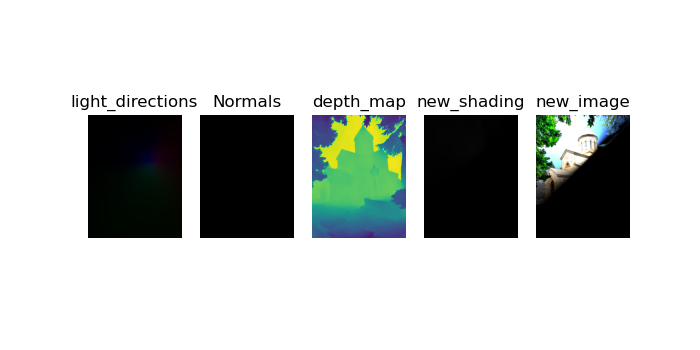

In [53]:
print(f"light_direction range[{np.min(surface_light_directions)}:{np.max(surface_light_directions)}, normal range [{np.min(normals)}:{np.max(normals)}]")
# surface_light_directions = (surface_light_directions + 1) / 2
surface_light_directions_dimmed = surface_light_directions * 0.5
normals = ((normals / 255) - 1) * 2
light_direction_times_normals = surface_light_directions_dimmed * normals
new_shading = np.sum(light_direction_times_normals, axis=2) / 3
new_shading = np.dstack([new_shading, new_shading, new_shading])
new_image = albedo * new_shading

fig, ax = plt.subplot_mosaic([['light_directions', 'normals', 'depth_map', 'new_shading', 'new_image']], figsize=(7, 3.5))
ax['light_directions'].imshow(surface_light_directions)
ax['light_directions'].axis('off')
ax['light_directions'].set_title('light_directions')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

ax['depth_map'].imshow(depth_map)
ax['depth_map'].axis('off')
ax['depth_map'].set_title('depth_map')

ax['new_shading'].imshow(new_shading)
ax['new_shading'].axis('off')
ax['new_shading'].set_title('new_shading')

ax['new_image'].imshow(new_image)
ax['new_image'].axis('off')
ax['new_image'].set_title('new_image')

#light_source = [(16, 14)]
#x, y = zip(*light_source)
#ax['image'].plot(x, y, 'o')

plt.show()

### Copy of Anya's relighting code

In [11]:
# Returns a normalized light vector with the same dimensions as the original image
def get_new_light_dir(light_dir, original_image):
    light_dir = np.array(light_dir)
    magnitude = np.sum(light_dir ** 2)
    normalized_light_dir = light_dir / magnitude

    new_light_dir = np.zeros(np.shape(original_image))
    new_light_dir[:] = normalized_light_dir

    return new_light_dir

In [16]:
def calculate_shading(light_dir, normals):
    #new_light_dir = get_new_light_dir(light_dir, normals)

    # Dot product (np.dot doesn't work for more than 2 dimensions)
    new_shading = normals * light_dir
    new_shading = np.sum(new_shading, axis=2) / 3
    # new_shading = new_shading * 0.5 + 1
    # new_shading = normals @ light_dir

    # Stack the single grayscale value in three RGB channels
    new_shading = np.dstack([new_shading, new_shading, new_shading])

    imshow(new_shading)

    # If we use the albedo_corrected in this equation (albedo ** 0.4545), the image looks a lot brighter
    # print(f"albedo range[{np.ndarray.min(albedo)}, {np.ndarray.max(albedo)}], new_shading range [{np.ndarray.min(new_shading)},{np.ndarray.max(new_shading)}]")
    new_image = albedo * new_shading
    # new_image = (new_image * 0.5) + 1

    # TODO: this gives us NaN values!
    # new_image = new_image ** 0.4545

    return new_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new_image.shape= (1216, 928, 3)


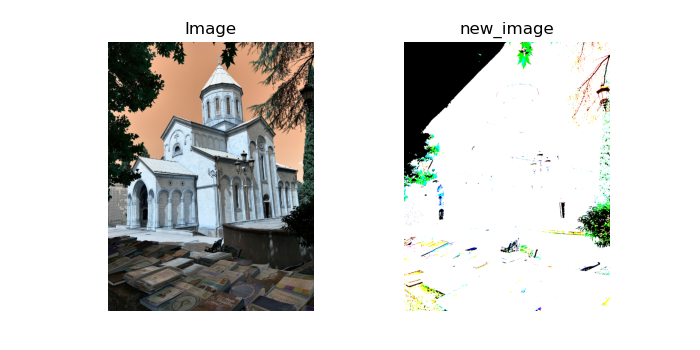

In [17]:
new_image = calculate_shading(surface_light_directions, normals)
print(f"{new_image.shape= }")

fig, ax = plt.subplot_mosaic([['image', 'new_image']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['new_image'].imshow(new_image)
ax['new_image'].axis('off')
ax['new_image'].set_title('new_image')

#light_source = [(16, 14)]
#x, y = zip(*light_source)
#ax['image'].plot(x, y, 'o')

plt.show()

### We will now use the above distance and direction vector fields to compute a masked direction vector

In [10]:
tolerance = 1e-2
reshaped_directions = direction_vector_field.reshape((-1, 3))
rounded_directions = np.round(reshaped_directions / tolerance) * tolerance # rounding to reduce number of rays / deal with numerical errors
unique_directions = np.unique(rounded_directions, axis=0)
print(f"{unique_directions.shape= }")
rays = [[] for _ in range(unique_directions.shape[0])]

for i, d in enumerate(unique_directions):
    indices = np.where(direction_vector_field[i] == d)
    rays[i] = indices

print(f"{rays[0]}")
# for ray in rays:
#     for point in ray:
#         if distances[ray]

unique_directions.shape= (86579, 3)


IndexError: index 1216 is out of bounds for axis 0 with size 1216

# Scratch / unsuccessful implementations

In [13]:
rgb_image = cv2.imread('data/mid_level_examples/church/input.png')
depth_map = cv2.imread('data/mid_level_examples/church/depth_bmd_ordinal.png', cv2.IMREAD_ANYDEPTH)

# Define camera intrinsic matrix and parameters
# TODO: Find the best way of setting these from the rgb image
fx, fy = 525.0, 525.0
cx, cy = 319.5, 239.5

# Define camera extrinsic matrix (position and orientation in 3D space)
camera_position = np.array([0, 0, 0])
camera_rotation = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

point_cloud = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3))
print(f"{point_cloud.shape= }")

# Loop through each pixel in the depth map and compute 3D point
for u in range(depth_map.shape[1]):
    for v in range(depth_map.shape[0]):
        Z = depth_map[v, u]
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        point_cloud[v, u] = [X, Y, Z]

# Rotate and translate point cloud to align with camera position
point_cloud = np.matmul(point_cloud, camera_rotation) + camera_position

print(f"{point_cloud.shape= }")


point_cloud.shape= (1216, 928, 3)
point_cloud.shape= (1216, 928, 3)


depth_map_grey.shape= (1216, 928)


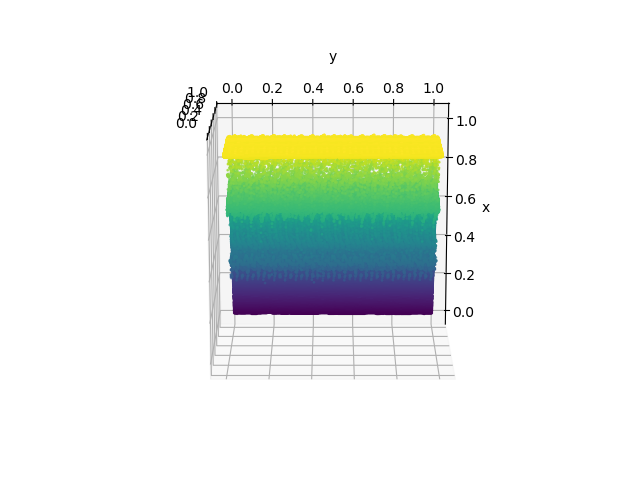

depth_map_grey.shape= (1216, 928)
np.amax(depth_map_grey)= 1.0, np.amin(depth_map_grey)= 0.0


In [8]:
# ps.init()

rgb_image = cv2.imread('data/mid_level_examples/church/input.png')
depth_map = cv2.imread('data/mid_level_examples/church/depth_bmd_ordinal.png')
depth_map_grey = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
depth_map_grey = depth_map_grey / 255
x = np.linspace(0, 1, num=depth_map_grey.shape[0])
y = np.linspace(0, 1, num=depth_map_grey.shape[1])
xx, yy = np.meshgrid(x, y)
print(f"{depth_map_grey.shape= }")

z = depth_map_grey.flatten()
z = 1 - z


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z, xx, yy, c=z, s=1)
ax.view_init(elev=-75, azim=0)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Define a function to update the plot for each frame of the animation
#def update(frame):
#    ax.view_init(elev=30, azim=frame)
#    return scatter,

# Create the animation
# anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 36), interval=50)

plt.show()


print(f"{depth_map_grey.shape= }")
print(f"{np.amax(depth_map_grey)= }, {np.amin(depth_map_grey)= }")

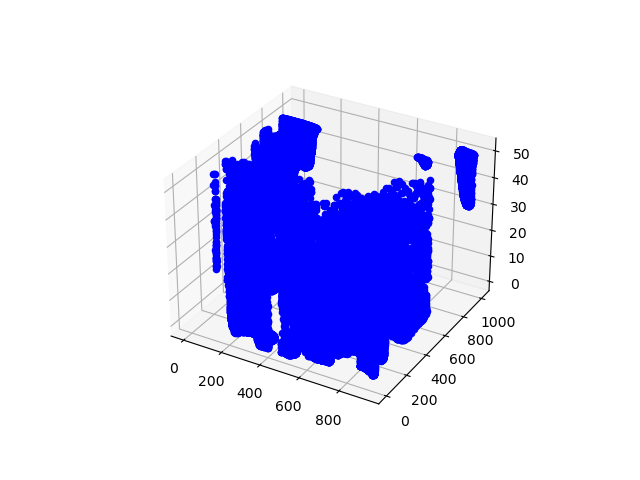

In [ ]:
# Alternate implementation
depth_map = cv2.imread('data/mid_level_examples/church/depth_metric_r20.png')
depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
height, width = depth_map.shape
depth_map = int((depth_map / np.max(depth_map)) * 16)
depth = np.max(depth_map)
print(f"{height= }, {width= },{depth= }")

dense_volume = np.zeros((height, width, depth))
for x in range(height):
    for y in range(width):
        d = depth_map[x, y]
        dense_volume[x, y, d-1] = 1


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate through each voxel and plot it if it is non-zero
print(f"Plotting values:")
for z in range(dense_volume.shape[2]):
    for y in range(dense_volume.shape[0]):
        for x in range(dense_volume.shape[1]):
            if dense_volume[y, x, z] > 0:
                ax.scatter(x, y, z, c='b', marker='o')

# Set the axis limits and labels
ax.set_xlim([0, dense_volume.shape[1]])
ax.set_ylim([0, dense_volume.shape[0]])
ax.set_zlim([0, dense_volume.shape[2]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

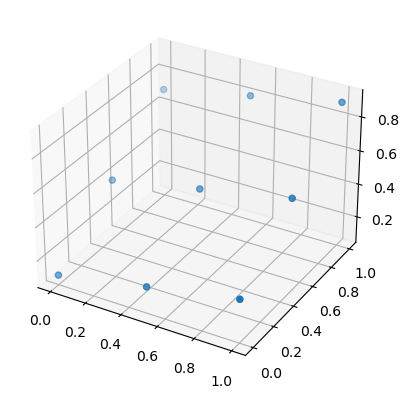

In [4]:
depth_map = np.array([[0.1, 0.2, 0.3],
                      [0.4, 0.5, 0.6],
                      [0.7, 0.8, 0.9]])

# Create a grid of evenly spaced x and y values
x = np.linspace(0, 1, num=3)
y = np.linspace(0, 1, num=3)
xx, yy = np.meshgrid(x, y)

# Use the depth map as the z-coordinates of the points
z = depth_map.flatten()

# Create a 3D plot of the points
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, z)
plt.show()